In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from scipy.io import loadmat
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
from itertools import product

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelBinarizer
import os


plt.style.use('ggplot')

### Bi-Class Classification

In [2]:
breast_cancer_path = 'data/bi-class/breast-cancer'
diabetes_path = 'data/bi-class/diabetes'
digit_path = 'data/bi-class/digit'
iris_path = 'data/bi-class/iris'
wine_path = 'data/bi-class/wine'

In [3]:
def load_biclass_data(folder_path):    
    data = []
    paths = ['train_X.npy', 'train_Y.npy', 'test_X.npy', 'test_Y.npy']
    for path in paths:        
        load_path = os.path.join(folder_path, path)
        data.append(np.load(load_path))
                
    return tuple(data)

def load_multiclass_data(folder_path):    
    data = []
    keys = ['train_images', 'train_labels', 'test_images', 'test_labels']
    for key in keys:        
        load_path = os.path.join(folder_path, '{}.mat'.format(key))
        data.append(np.squeeze(loadmat(load_path)[key]))
                
    return tuple(data)

def plot_confusion_mat(y_true, y_pred):
    plt.figure()
    cfm = confusion_matrix(y_true, y_pred, normalize='pred')
    
    sns.heatmap(cfm, annot=True, fmt='.2g', cmap=cm.Blues, cbar=True)
    plt.xlabel('Predicted labels');plt.ylabel('True labels')
    
    
def plot_avg_cross_val_acc(h_acc):
    
    H = list(range(1, 11))
    
    plt.figure()
    
    plt.scatter(H, h_acc, c='b')
    
    plt.plot(H, h_acc, color='b')
    
    plt.fill_between(H, h_acc, np.mean(h_acc), alpha=0.4, color='b')
    
    plt.xlabel('H')
    
    plt.ylabel('Avg. Val. Accuracy')
    

In [7]:
class Net1H(nn.Module):
    
    def __init__(self, n_features, n_class, H):
        super(Net1H, self).__init__()
        
        self.input = nn.Linear(n_features, H)
        
        self.hidden_layer = nn.Linear(H, H)
        
        self.output = nn.Linear(H, n_class)
        
    def forward(self, x):
        
        x = F.relu(self.input(x))
        x = F.relu(self.hidden_layer(x))
        
        return torch.softmax(self.output(x), dim=1)   
    
def Tune(data, H=[], lr=0.001):
    X_train, Y_train, X_test, Y_test = data

    h_acc = []
    for h in H:
        shuffle = ShuffleSplit(n_splits=5, random_state=22)
    
        split = shuffle.split(X_train)
        
        acc = []
        for i, (train_i, val_i) in enumerate(split):
            x_train = X_train[train_i]
            
            y_train = Y_train[train_i]
            
            x_val = X_train[val_i]
            
            y_val = Y_train[val_i]
            
            data = (x_train, y_train, x_val, y_val)
            
            net = Net1H(x_train.shape[1], 2, h)
            
            
            loss = nn.CrossEntropyLoss()
            opt = optim.Adam(net.parameters(), lr=lr)
            
            a, _ = Train(net, opt, loss, data)
            
            acc.append(a)
            
        avg_acc = np.mean(acc)
        
        print("H = {} : {}".format(h, avg_acc))
        
        h_acc.append(avg_acc)
        
    return np.argmax(h_acc) + 1, np.max(h_acc), h_acc
    
    
    
def Train(net, opt, loss, data, epochs=150):
    device = torch.device("cuda:0")
    
    torch.cuda.empty_cache()
    
    net = net.to(device)
    loss = loss.to(device)
    
    x_train, y_train, x_val, y_val = data
    
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.squeeze(torch.from_numpy(y_train).long())
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.squeeze(torch.from_numpy(y_val).long())
    
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_val = x_val.to(device)
    y_val = y_val.to(device)
    
    for epoch in range(epochs):
        Y_pred = net(x_train)
        train_loss = loss(Y_pred, y_train)

        opt.zero_grad()
        train_loss.backward()
        opt.step()
    
    y_pred = net(x_val)
    y_pred = torch.argmax(y_pred, dim=1)
    y_pred = y_pred.detach().to('cpu').numpy()
    y_val = y_val.detach().to('cpu').numpy()
    acc = accuracy_score(y_pred, y_val)
    
    torch.cuda.empty_cache()
    return acc, y_pred

##### Breast Cancer

H = 1 : 0.6872727272727273
H = 2 : 0.6254545454545455
H = 3 : 0.6254545454545455
H = 4 : 0.8836363636363636
H = 5 : 0.8363636363636363
H = 6 : 0.9236363636363636
H = 7 : 0.949090909090909
H = 8 : 0.8545454545454545
H = 9 : 0.9563636363636364
H = 10 : 0.9636363636363636
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93        48
         1.0       0.94      1.00      0.97        88

    accuracy                           0.96       136
   macro avg       0.97      0.94      0.95       136
weighted avg       0.96      0.96      0.96       136



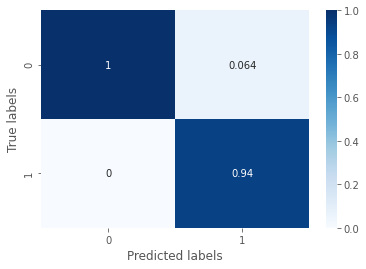

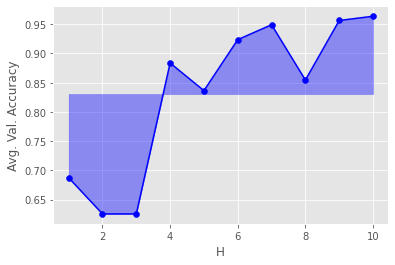

In [113]:
data = load_biclass_data(breast_cancer_path)

H = list(range(1,11))
best_H, best_acc, h_acc = Tune(data, H)

net = Net1H(data[0].shape[1], 2, best_H)
                       
loss = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.001)

acc, y_pred = Train(net, opt, loss, data)

y_test = data[3]

print(classification_report(y_test, y_pred))

plot_confusion_mat(y_test, y_pred)

plot_avg_cross_val_acc(h_acc)

##### Diabetes

H = 1 : 0.6903225806451612
H = 2 : 0.535483870967742
H = 3 : 0.535483870967742
H = 4 : 0.6935483870967742
H = 5 : 0.7193548387096774
H = 6 : 0.6258064516129032
H = 7 : 0.7
H = 8 : 0.7419354838709676
H = 9 : 0.7290322580645162
H = 10 : 0.7161290322580646
              precision    recall  f1-score   support

         0.0       0.71      0.28      0.40        54
         1.0       0.70      0.94      0.81        99

    accuracy                           0.71       153
   macro avg       0.71      0.61      0.60       153
weighted avg       0.71      0.71      0.66       153



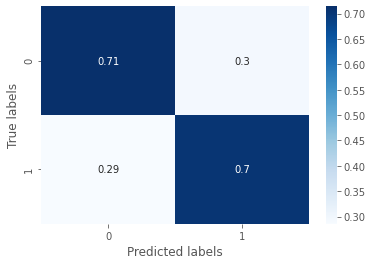

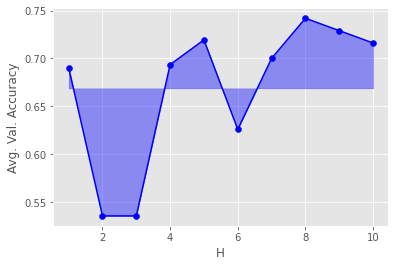

In [114]:
data = load_biclass_data(diabetes_path)

best_H, best_acc, h_acc = Tune(data, H)

net = Net1H(data[0].shape[1], 2, best_H)
                       
loss = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.001)

acc, y_pred = Train(net, opt, loss, data)

y_test = data[3]
print(classification_report(y_test, y_pred))
plot_confusion_mat(y_test, y_pred)

plot_avg_cross_val_acc(h_acc)

#### digit

H = 1 : 0.5574999999999999
H = 2 : 0.85
H = 3 : 0.915
H = 4 : 0.89
H = 5 : 0.8949999999999999
H = 6 : 0.9375
H = 7 : 0.9574999999999999
H = 8 : 0.9400000000000001
H = 9 : 0.9550000000000001
H = 10 : 0.9574999999999999
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        91
           1       0.98      0.95      0.97       109

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200



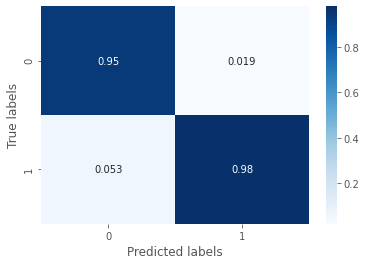

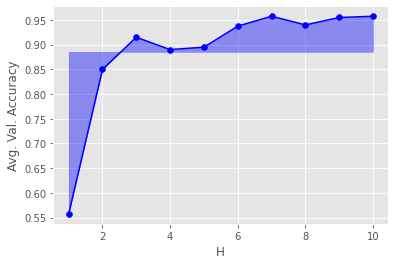

In [115]:
data = load_biclass_data(digit_path)

best_H, best_acc, h_acc = Tune(data, H)

net = Net1H(data[0].shape[1], 2, best_H)
                       
loss = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.001)

acc, y_pred = Train(net, opt, loss, data)

y_test = data[3]
print(classification_report(y_test, y_pred))
plot_confusion_mat(y_test, y_pred)

plot_avg_cross_val_acc(h_acc)

#### Iris

H = 1 : 0.65
H = 2 : 0.55
H = 3 : 0.6166666666666666
H = 4 : 0.75
H = 5 : 0.9
H = 6 : 0.85
H = 7 : 0.9333333333333332
H = 8 : 0.7166666666666666
H = 9 : 0.9166666666666666
H = 10 : 0.8166666666666667
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.69      1.00      0.82        20

    accuracy                           0.70        30
   macro avg       0.84      0.55      0.50        30
weighted avg       0.79      0.70      0.60        30



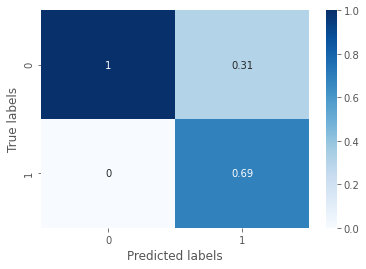

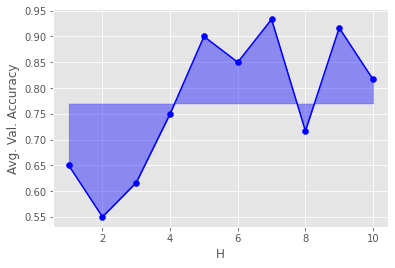

In [116]:
data = load_biclass_data(iris_path)

best_H, best_acc, h_acc = Tune(data, H)

net = Net1H(data[0].shape[1], 2, best_H)
                       
loss = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.001)

acc, y_pred = Train(net, opt, loss, data)

y_test = data[3]
print(classification_report(y_test, y_pred))
plot_confusion_mat(y_test, y_pred)

plot_avg_cross_val_acc(h_acc)

#### Wine

H = 1 : 0.5599999999999999
H = 2 : 0.6266666666666667
H = 3 : 0.6666666666666667
H = 4 : 0.44000000000000006
H = 5 : 0.4800000000000001
H = 6 : 0.6
H = 7 : 0.6533333333333333
H = 8 : 0.52
H = 9 : 0.6933333333333334
H = 10 : 0.68
              precision    recall  f1-score   support

           0       0.76      0.73      0.74        22
           1       0.60      0.64      0.62        14

    accuracy                           0.69        36
   macro avg       0.68      0.69      0.68        36
weighted avg       0.70      0.69      0.70        36



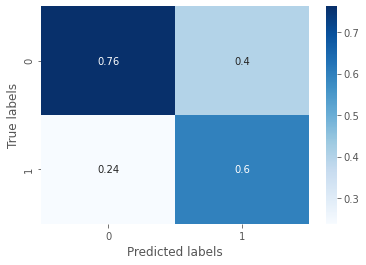

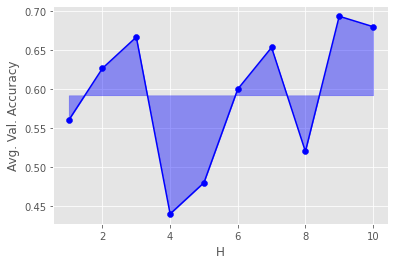

In [117]:
data = load_biclass_data(wine_path)

best_H, best_acc, h_acc = Tune(data, H)

net = Net1H(data[0].shape[1], 2, best_H)
                       
loss = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.001)

acc, y_pred = Train(net, opt, loss, data)

y_test = data[3]
print(classification_report(y_test, y_pred))
plot_confusion_mat(y_test, y_pred)

plot_avg_cross_val_acc(h_acc)

## Multi-Class Classification

In [16]:
class Net2H(nn.Module):
    
    def __init__(self, n_features, n_class, H1, H2):
        super(Net2H, self).__init__()
        
        self.input = nn.Linear(n_features, H1)
        
        self.hidden1 = nn.Linear(H1, H2)
        
        self.hidden2 = nn.Linear(H2, H2)
        
        self.output = nn.Linear(H2, n_class)
        
    def forward(self, x):
        
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        
        return torch.softmax(self.output(x), dim=1)
    
    
    
def Tune2H(data, H1=[], H2=[], lr=0.0001):
    X_train, Y_train, X_test, Y_test = data
    H = np.array(list(product(H1, H2)))
    h_acc = []
    for h in H:
        shuffle = ShuffleSplit(n_splits=5, random_state=22)
    
        split = shuffle.split(X_train)
        
        acc = []
        for i, (train_i, val_i) in enumerate(split):
            x_train = X_train[train_i]
            
            y_train = Y_train[train_i]
            
            x_val = X_train[val_i]
            
            y_val = Y_train[val_i]
            
            data = (x_train, y_train, x_val, y_val)
            
            net = Net2H(x_train.shape[1], 10, h[0], h[1])
            
            
            loss = nn.CrossEntropyLoss()
            opt = optim.Adam(net.parameters(), lr=lr)
            
            a, _ = Train(net, opt, loss, data, 1000)
            
            acc.append(a)
            
        avg_acc = np.mean(acc)
        
        print("H = {} : {}".format(h, avg_acc))
        
        h_acc.append(avg_acc)
        
    return H[np.argmax(h_acc)], np.max(h_acc), h_acc

H = [50 10] : 0.7323999999999999
H = [50 15] : 0.6628
H = [50 20] : 0.6472
H = [75 10] : 0.7266
H = [75 15] : 0.607
H = [75 20] : 0.7292
H = [100  10] : 0.6078
H = [100  15] : 0.6452
H = [100  20] : 0.6614


/home/kam/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       107
           1       0.96      0.95      0.96       105
           2       0.65      0.84      0.74       111
           3       0.60      0.82      0.69        93
           4       0.82      0.72      0.77       115
           5       0.92      0.89      0.90        87
           6       0.44      0.71      0.54        97
           7       0.89      0.96      0.92        95
           8       0.97      0.92      0.94        95
           9       0.95      0.93      0.94        95

    accuracy                           0.76      1000
   macro avg       0.72      0.77      0.74      1000
weighted avg       0.71      0.76      0.73      1000



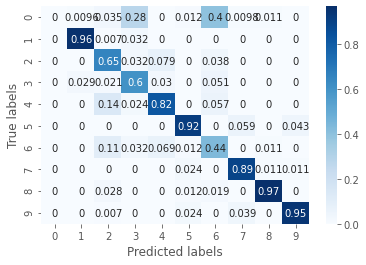

In [30]:
image_path = 'data/multi-class'

data = load_multiclass_data(image_path)

H1 = [50, 75, 100]
H2 = [10, 15, 20]

best_H, best_acc, h_acc = Tune2H(data, H1, H2)

net = Net2H(data[0].shape[1], 10, best_H[0], best_H[1])
                       
loss = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.0001)

acc, y_pred = Train(net, opt, loss, data, 1000)

y_test = data[3]
print(classification_report(y_test, y_pred))
plot_confusion_mat(y_test, y_pred)

Text(0, 0.5, 'Avg. Val. Accuracy')

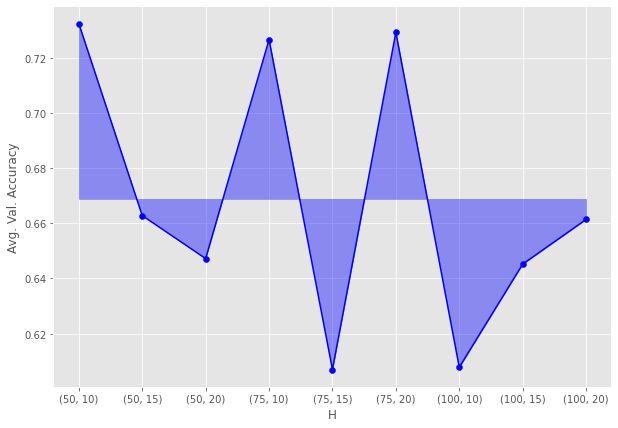

In [31]:
plt.figure(figsize=(10, 7))

H_label = list(product(H1, H2))

H = list(range(0,9))
    
plt.scatter(H, h_acc, c='b')
    
plt.plot(H, h_acc, color='b')
    
plt.fill_between(H, h_acc, np.mean(h_acc), alpha=0.4, color='b')

plt.xticks(H, H_label)
    
plt.xlabel('H')
    
plt.ylabel('Avg. Val. Accuracy')